Initial set up, including search terms.

In [1]:
import sys

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
wos_config = wosis.load_config("config.yml")

In [4]:
search_terms={
    "inclusive_kw":("sensitivity analysis", "uncertainty analysis", "uncertainty quantification", "uncertainty propagation", 
                    "local sensitivity analysis", "LSA", "one-at-a-time", 
                    "OAT", "global sensitivity analysis", "GSA", "all-at-a-time", "AAT"),
"subject_area":("ENVIRONMENTAL SCIENCES", "WATER RESOURCES", "ENGINEERING ENVIRONMENTAL", "INTERDISCIPLINARY APPLICATIONS"),
}

In [5]:
topics = [wosis.build_query(search_terms),]
topics

['TS=("sensitivity analysis" OR "uncertainty analysis" OR "uncertainty quantification" OR "uncertainty propagation" OR "local sensitivity analysis" OR "LSA" OR "one-at-a-time" OR "OAT" OR "global sensitivity analysis" OR "GSA" OR "all-at-a-time" OR "AAT") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

In [6]:
%%time
overwrite = False
id_to_query, query_recs = wosis.query(topics, overwrite, wos_config, time_span={'begin':'2010-01-01','end':'2017-12-31'})

Authenticated (SID: 7AhUidbvHOFS3XiGLlT)


c:\userdata\douglasd\project\biblio\wosis\wosis\query.py:293: UserWarning: Using cached results...
  warnings.warn("Using cached results...")


Got 15854 records
Wall time: 12.8 s


In [7]:
with open('tmp/example_query_id.txt', 'w') as file:
    file.write(json.dumps(id_to_query, indent=2))

In [8]:
query_id=list(id_to_query)[0]
print("Query ID: ", query_id, "\nQuery String:", id_to_query[query_id], "\n")
RC=mk.RecordCollection("tmp/{}.txt".format(query_id))
print("Corpora consists of", len(RC), "Publications")

Query ID:  756d39801152fe5f5f4ad3a3df9b6a30_2010-01-01-2017-12-31 
Query String: TS=("sensitivity analysis" OR "uncertainty analysis" OR "uncertainty quantification" OR "uncertainty propagation" OR "local sensitivity analysis" OR "LSA" OR "one-at-a-time" OR "OAT" OR "global sensitivity analysis" OR "GSA" OR "all-at-a-time" OR "AAT") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS") 

Corpora consists of 15754 Publications


In [9]:
RC = list(query_recs.values())[0]
print("Corpora consists of", len(RC), "Publications")

Corpora consists of 15754 Publications


In [10]:
from datetime import datetime
repset_df = pd.DataFrame(RC.forNLP(extraColumns=["AU", "SO", "DE"]))
repset_df = repset_df.drop(["keywords", "abstract"], axis=1)

assert len(repset_df.id.unique()) == len(repset_df.id), "Duplicate records found!"

repset_fn = "../data/{}.csv".format(query_id)
with open(repset_fn, 'w') as fn:
    fn.write("# Data from Clarivate Analytics' Web of Science, retrieved 5 December 2018\n")
    fn.write("# This file generated on {}\n".format(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
    repset_df.index.name = "item"
    repset_df.to_csv(fn)

In [11]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

<hr>

Search for paper of interest in the corpora.

In [12]:
corpora_df = pd.DataFrame(RC.forNLP(extraColumns=["AU", "SO", "DE", 'DOI']))
corpora_df.loc[corpora_df['DOI'] == '', 'DOI'].count()

corpora_df = corpora_df.loc[corpora_df['DOI'] != '', :]

In [13]:
corpora_df.loc[corpora_df['DOI'] == '10.1016/j.jocs.2015.08.008', :]

,id,year,title,keywords,abstract,AU,SO,DE,DOI
10432,WOS:000367774700005,2015,Chaospy: An open source tool for designing met...,,the paper describes the philosophy design func...,"Feinberg, Jonathan|Langtangen, Hans Petter",JOURNAL OF COMPUTATIONAL SCIENCE,uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008


<hr>

Further refinements to the corpora.

In [14]:
from wosis.analysis import remove_by_journals, remove_by_title

# List of unrelated Journals - will be matched by partial string
unrelated_jo = ['PSYCHOL', 'BIOINFO', 'BUSINESS INFORMATION', 'MANUFACTURING', 
                'BIOLOGICALLY INSPIRED COGNITIVE ARCHITECTURES', 'COMPLEXITY', 'INDUSTRIAL ECOLOGY',
                'QUANTITATIVE FINANCE', 'VIRTUAL REALITY', 'COMMUNICATION NETWORKS', 'COMPUTER METHODS AND PROGRAMS IN BIOMEDICINE',
                'ARTIFICIAL INTELLIGENCE IN EDUCATION', 'INSURANCE MATHEMATICS & ECONOMICS', 'ASTIN BULLETIN', 
                'COMMUNICATION TECHNOLOGY', 'COMPUTERS & STRUCTURES', 'CHEMOSPHERE', 'VISUAL COMPUTING',
                'INTERNATIONAL CONFERENCE ON COMPUTER SCIENCE AND APPLICATIONS', 'WASTE MANAGEMENT', 'OPTIMIZATION AND ENGINEERING',
                'COMPUTERS & OPERATIONS RESEARCH',
                'PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON EDUCATION, MATHEMATICS AND SCIENCE 2016',
                'COMPUTATIONAL MECHANICS',

               ]

# Think of the parameter order like "with this dataset, remove these unrelated journals"
# corpora_df = remove_by_journals(corpora_df, unrelated_jo)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,year,title,AU,SO
0,2014,Avian diversity in a suburban park system: cur...,"Rush, Scott A.|Romito, Tom|Robison, Terry L.",URBAN ECOSYSTEMS
1,2016,Environmental life cycle assessment of grain m...,"Boone, Lieselot|Van Linden, Veerle|De Meester,...",SCIENCE OF THE TOTAL ENVIRONMENT
2,2014,Global sensitivity analysis for subsoil parame...,"Miro, S.|Hartmann, D.|Schanz, T.",COMPUTERS AND GEOTECHNICS
3,2007,Local scale vehicles pollution study in the ab...,"Assael, M. J.|Delaki, M.|Kakosimos, K.|Borrego...",AIR POLLUTION XV
4,2009,Population-based local search for protein fold...,"Kapsokalivas, L.|Gan, X.|Albrecht, A. A.|Stein...",COMPUTATIONAL BIOLOGY AND CHEMISTRY


In [15]:
unrelated_TI = ['transportation networks', 'Travel Destination', 'portfolio optimization']

# Again, with this dataset remove these titles
corpora_df = remove_by_title(corpora_df, unrelated_TI)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

transportation networks: 0
Travel Destination: 0
portfolio optimization: 0


,year,title,AU,SO
0,2014,Avian diversity in a suburban park system: cur...,"Rush, Scott A.|Romito, Tom|Robison, Terry L.",URBAN ECOSYSTEMS
1,2016,Environmental life cycle assessment of grain m...,"Boone, Lieselot|Van Linden, Veerle|De Meester,...",SCIENCE OF THE TOTAL ENVIRONMENT
2,2014,Global sensitivity analysis for subsoil parame...,"Miro, S.|Hartmann, D.|Schanz, T.",COMPUTERS AND GEOTECHNICS
3,2007,Local scale vehicles pollution study in the ab...,"Assael, M. J.|Delaki, M.|Kakosimos, K.|Borrego...",AIR POLLUTION XV
4,2009,Population-based local search for protein fold...,"Kapsokalivas, L.|Gan, X.|Albrecht, A. A.|Stein...",COMPUTATIONAL BIOLOGY AND CHEMISTRY


In [16]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

<hr>

Plotting

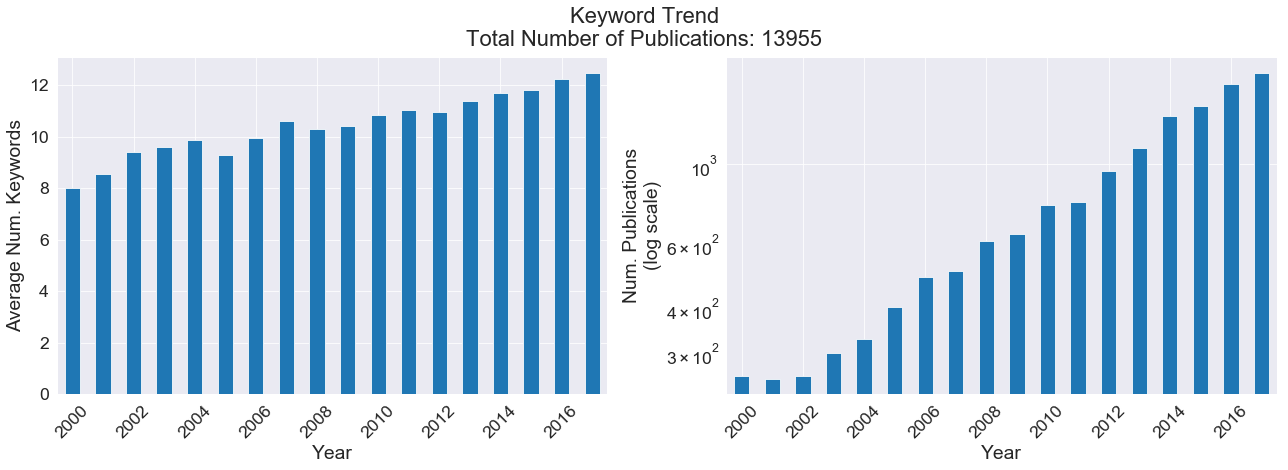

In [17]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=False)

In [22]:
criteria = {
    'overarching': set(['uncertainty', 'adapt', 'decision support', 'management', 'gis']),
    'agri': set(['agricultur', 'farm']),
    'water': set(['hydrology', 'water', 'stream', 'aquifer']),
    'enviro': set(['environment', 'climate', 'ecology', 'ecosystem', 'biodivers']),
    'socio_economic': set(['ecosystem service', 'social', 'conflict', 'particip', 'law', 'stakehold', 'policy', 'economic'])
}

crit_matches = wosis.analysis.search.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

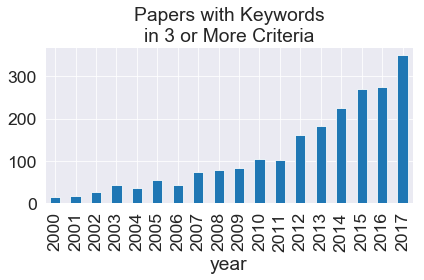

In [26]:
criteria_df = wosis.analysis.search.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=3)